На выходе нас интересуют следующие данные:

☑ ABC / XYZ - анализ товарной номенклатуры и клиентской базы

☑ Когортный анализ клиентов

☑ Сформулированные выводы и предложения по сегментированию базы и товарной номенклатуры

## Когортный анализ

In [1]:
import pandas as pd
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt # graphs
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows',6)

with pd.option_context('display.max_rows', None):
    print(df.groupby(['РегионКонтрагента'])['Количество'].sum())

In [2]:
df = pd.read_excel('~/Documents/IM_Sales.xlsx',
                   dtype={'КодКонтрагента':'category',
                          'ТипКонтрагента':'category',
                          'РегионКонтрагента':'category',
                          'ДатаПродажи':str,
                          'Ответственный':'category',
                          'КодНоменклатуры':'category',
                          'НомерПродажи':'category'
                         })

<ipython-input-2-687eac060312>:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.read_excel('~/Documents/IM_Sales.xlsx',


In [3]:
df = df.drop_duplicates()
df.drop(
    columns=['ИННКонтрагента','Контрагент','Номенклатура','СтоимостьПродажиСНДС','НДС',\
             'СебестоимостьИлиСтоимостьПоПрайсу','РасчетнаяПрибыль'], inplace = True)

In [4]:
#fill numeric cols with 0
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(0)

#fill object cols with null
string_columns = df.select_dtypes(include=['object']).columns
df[string_columns] = df[string_columns].fillna('null')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8441 entries, 0 to 8440
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   КодКонтрагента          8441 non-null   category
 1   ТипКонтрагента          8441 non-null   category
 2   РегионКонтрагента       8309 non-null   category
 3   ДатаПродажи             8441 non-null   object  
 4   НомерПродажи            8441 non-null   category
 5   Ответственный           8418 non-null   category
 6   КодНоменклатуры         8441 non-null   category
 7   Количество              8441 non-null   int64   
 8   СтоимостьПродажиБезНДС  8441 non-null   float64 
dtypes: category(6), float64(1), int64(1), object(1)
memory usage: 812.1+ KB


Меняем форматы

In [6]:
df['ДатаПродажи'] = pd.to_datetime(df['ДатаПродажи'])

In [7]:
#Возвраты не обнаруживаем
df[df['Количество']<0].count().sum()

0

In [8]:
#Заполняем категориальне пропуски
df['РегионКонтрагента'].fillna(df['РегионКонтрагента'].mode()[0], inplace=True)
df['Ответственный'].fillna(df['Ответственный'].mode()[0], inplace=True)

In [9]:
df.isna().sum().sum()

0

Визуально ознакомимся с основными закономерностями датасета 

In [10]:
df_graph = df[['ДатаПродажи','Количество']].copy()
df_graph['ГодПродажи'] = pd.DatetimeIndex(df['ДатаПродажи']).year
df_graph['МесяцПродажи'] = pd.DatetimeIndex(df['ДатаПродажи']).month
df_graph['ДеньПродажи'] = pd.DatetimeIndex(df['ДатаПродажи']).day

In [11]:
df_graph = df_graph.groupby(['ГодПродажи','МесяцПродажи','ДеньПродажи'])['Количество'].sum().reset_index()

In [12]:
df_graph

,ГодПродажи,МесяцПродажи,ДеньПродажи,Количество
0,2020,1,6,20
1,2020,1,9,25
2,2020,1,10,21
...,...,...,...,...
727,2023,10,1,5
728,2023,11,1,3
729,2023,12,1,2


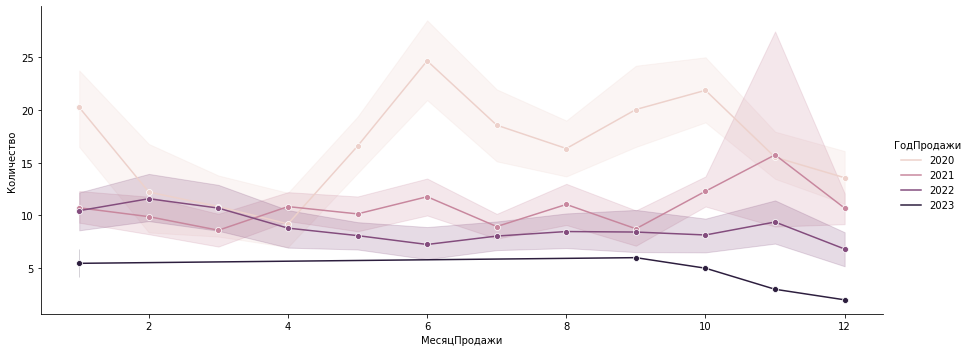

In [13]:
p = sns.relplot(kind='line', data=df_graph, 
                x=df_graph['МесяцПродажи'], y=df_graph['Количество'], hue=df_graph['ГодПродажи'],
                aspect=2.5, marker='o')

Часть 0. Когортный анализ

In [14]:
import warnings
from operator import attrgetter
import matplotlib.colors as mcolors

Создаем копию модели

Рассчитываем совокупный показатель, показывающий, сколько покупок было совершено каждым клиентом

In [15]:
train_df = df.copy()   #df['КодНоменклатуры'] == '1780']
#train_df.drop(columns=['КодНоменклатуры'], inplace = True)

In [16]:
n_sales = train_df.groupby(['КодКонтрагента'])['ДатаПродажи'].nunique()
mult_sales_perc = np.sum(n_sales > 1) / df['КодКонтрагента'].nunique()
print(f'{100 * mult_sales_perc:.2f}% контрагентов купили больше одного раза')

21.56% контрагентов купили больше одного раза


Построим график распределения покупок по контрагентам

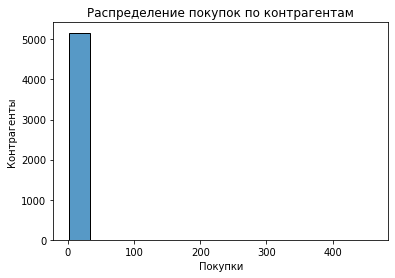

In [17]:
ax = sns.histplot(n_sales, kde=False)
ax.set(title='Распределение покупок по контрагентам',
       xlabel='Покупки', 
       ylabel='Контрагенты');

In [18]:
n_sales[n_sales>15]

КодКонтрагента
05974    29
09601    19
10018    19
         ..
35386    17
39922    17
40283    26
Name: ДатаПродажи, Length: 19, dtype: int64

Находим выброс по контрагенту 11921 и удаляем из датасета 

In [19]:
train_df = train_df[train_df['КодКонтрагента']!='11921'] #

21.54% контрагентов купили больше раза


[Text(0.5, 1.0, 'Распределение покупок по контрагентам'),
 Text(0.5, 0, 'Покупки'),
 Text(0, 0.5, 'Контрагенты')]

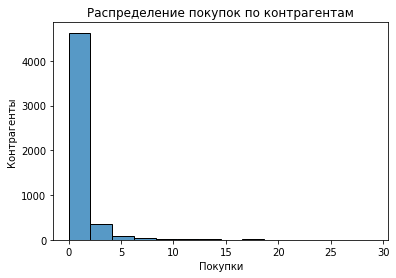

In [20]:
n_sales = train_df.groupby(['КодКонтрагента'])['ДатаПродажи'].nunique()
mult_sales_perc = np.sum(n_sales > 1) / df['КодКонтрагента'].nunique()
print(f'{100 * mult_sales_perc:.2f}% контрагентов купили больше раза')
ax = sns.histplot(n_sales, kde=False)
ax.set(title='Распределение покупок по контрагентам',
       xlabel='Покупки', 
       ylabel='Контрагенты')

Датасет не содержит дату регистрации клиента, поэтому предполагаем: первая когорта - дата первой покупки. 

In [21]:
train_df['order_month'] = train_df['ДатаПродажи'].dt.to_period('M')
train_df['cohort'] = train_df.groupby('КодКонтрагента')['ДатаПродажи'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [22]:
train_df

,КодКонтрагента,ТипКонтрагента,РегионКонтрагента,ДатаПродажи,НомерПродажи,Ответственный,КодНоменклатуры,Количество,СтоимостьПродажиБезНДС,order_month,cohort
6,16099,"Коммерческие, торговые компании",Новосибирская обл,2020-03-02 11:37:17,СТ000000603,Куценко Максим Владимирович,1780,1,791.67,2020-03,2020-03
7,28423,"Коммерческие, торговые компании",Москва г,2020-03-02 11:47:27,СТ000000543,Миронович Игорь Николаевич,4534,1,1000.00,2020-03,2020-03
8,29823,Физические лица,Московская обл,2020-03-02 12:29:01,ПЛ000000241,Куценко Максим Владимирович,1780,1,400.00,2020-03,2020-03
...,...,...,...,...,...,...,...,...,...,...,...
8438,28650,"Коммерческие, торговые компании",Московская обл,2023-01-02 10:02:27,ПЛ000000135,Аракчеева Ольга Павловна,4534,1,450.00,2023-01,2020-01
8439,48813,Физические лица,Московская обл,2023-01-02 15:57:39,ПЛ000000144,Куценко Максим Владимирович,4534,1,550.00,2023-01,2023-01
8440,48823,Физические лица,Москва г,2023-01-02 16:05:31,ПЛ000000145,Миронович Игорь Николаевич,4534,1,450.00,2023-01,2023-01


Агрегируем данные по cohort и order_month и считаем количество уникальных клиентов в каждой группе. 
Кроме того, добавляем period_number, который указывает количество периодов между месяцем когорты и месяцем покупки.

In [23]:
df_cohort = train_df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('КодКонтрагента', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [24]:
df_cohort

,cohort,order_month,n_customers,period_number
0,2020-01,2020-01,77,0
1,2020-01,2020-02,2,1
2,2020-01,2020-03,2,2
...,...,...,...,...
630,2023-10,2023-10,5,0
631,2023-11,2023-11,1,0
632,2023-12,2023-12,2,0


In [25]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [26]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,42,43
cohort,,,,,,,,,,,,,,,,,,,,,
2020-01,77.0,2.0,2.0,1.0,4.0,5.0,3.0,5.0,NaN,1.0,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,NaN,NaN
2020-02,163.0,5.0,3.0,9.0,15.0,16.0,13.0,13.0,17.0,12.0,...,2.0,1.0,5.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN
2020-03,151.0,2.0,10.0,8.0,12.0,4.0,13.0,11.0,5.0,5.0,...,2.0,5.0,2.0,4.0,2.0,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [28]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,42,43
cohort,,,,,,,,,,,,,,,,,,,,,
2020-01,1.0,0.025974,0.025974,0.012987,0.051948,0.064935,0.038961,0.064935,NaN,0.012987,...,NaN,NaN,NaN,0.012987,0.012987,0.012987,0.012987,0.025974,NaN,NaN
2020-02,1.0,0.030675,0.018405,0.055215,0.092025,0.098160,0.079755,0.079755,0.104294,0.073620,...,0.012270,0.006135,0.030675,0.006135,0.012270,NaN,NaN,NaN,NaN,NaN
2020-03,1.0,0.013245,0.066225,0.052980,0.079470,0.026490,0.086093,0.072848,0.033113,0.033113,...,0.013245,0.033113,0.013245,0.026490,0.013245,0.013245,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


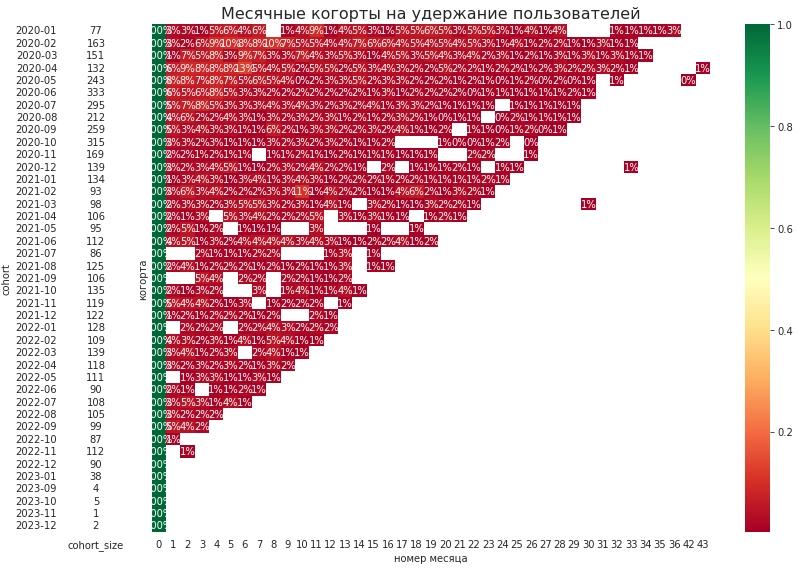

In [29]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Месячные когорты на удержание пользователей', fontsize=16)
    ax[1].set(xlabel='номер месяца',
              ylabel='когорта')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

In [30]:
df_coh1 = train_df.groupby(['cohort', 'order_month']).agg(\
                n_customers=('КодКонтрагента', 'nunique'),\
                count = ('Количество','sum'),
                avg_rev =('СтоимостьПродажиБезНДС','mean')) \
                .reset_index(drop=False)
df_coh1['period_number'] = (df_coh1.order_month - df_coh1.cohort).apply(attrgetter('n'))

In [31]:
df_coh1.sort_values(by='count', ascending=True).head(5)

,cohort,order_month,n_customers,count,avg_rev,period_number
472,2021-06,2022-08,1,1,833.33,14
352,2020-12,2022-10,1,1,541.67,22
92,2020-03,2022-04,1,1,291.67,25
476,2021-06,2022-12,1,1,558.33,18
350,2020-12,2022-08,1,1,283.33,20


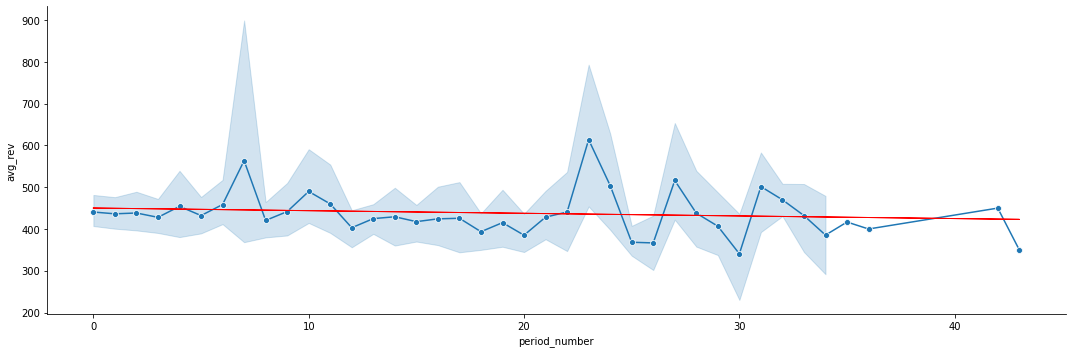

In [32]:
kg_avg_rev = sns.relplot(kind='line', data=df_coh1, 
                x=df_coh1['period_number'], 
                y=df_coh1['avg_rev'], 
                aspect=3, marker='o')
a, b = np.polyfit(df_coh1['period_number'], df_coh1['avg_rev'], 1)
plt.plot(df_coh1['period_number'], a*df_coh1['period_number']+b, color='r', linestyle='-', linewidth=1)


RFM анализ

http://dfedorov.spb.ru/pandas/%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D1%82%D0%B8%D0%BF%D0%B0%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%20%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B8%20%D0%B2%20pandas.html

In [33]:
import datetime as dt
now =  dt.datetime(2021,1,1)

In [34]:
raw_rfm = train_df[(train_df['ДатаПродажи'] >='2020-1-1') & (train_df['ДатаПродажи'] < '2021-1-1')]

In [35]:
raw_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3304 entries, 6 to 3660
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   КодКонтрагента          3304 non-null   category      
 1   ТипКонтрагента          3304 non-null   category      
 2   РегионКонтрагента       3304 non-null   category      
 3   ДатаПродажи             3304 non-null   datetime64[ns]
 4   НомерПродажи            3304 non-null   category      
 5   Ответственный           3304 non-null   category      
 6   КодНоменклатуры         3304 non-null   category      
 7   Количество              3304 non-null   int64         
 8   СтоимостьПродажиБезНДС  3304 non-null   float64       
 9   order_month             3304 non-null   period[M]     
 10  cohort                  3304 non-null   period[M]     
dtypes: category(6), datetime64[ns](1), float64(1), int64(1), period[M](2)
memory usage: 663.1 KB


In [36]:
rfm = raw_rfm.groupby('КодКонтрагента').agg(\
                                       {'ДатаПродажи' : lambda day : (now - day.max()).days,
                                        'НомерПродажи': lambda num : len(num),
                                        'СтоимостьПродажиБезНДС': lambda price : price.sum()
 })
col_list = ['Recency','Frequency','Monetary']  
rfm.columns = col_list

Разделим данные ('Recency','Frequency','Monetary') на несколько сегментов для дальнейшего анализа.
В коде для Recency числа поменяны местами так как более низкая Recency для нас лучше.

In [37]:
cut_labels_r = [1,2,3,4,5]
cut_bins_r = [0,30,60,90,180,10000]
rfm["R"] = pd.cut(rfm["Recency"], bins=cut_bins_r, labels=cut_labels_r)
cut_labels_f = [1,2,3,4,5]
cut_bins_f = [0,1,2,3,5,10000]
rfm["F"] = pd.cut(rfm["Frequency"], bins=cut_bins_f, labels=cut_labels_f)
cut_labels_m = [1,2,3,4,5]
cut_bins_m = [0,101,201,501,1001,10000]
rfm["M"] = pd.cut(rfm["Monetary"], bins=cut_bins_m, labels=cut_labels_m)

Проверим все категоризированные выше признаки 

In [38]:
#для Recency
tbl = rfm.groupby(['Recency'])['R'].count().reset_index()
tbl.query("R > 0 & Recency <= 30")['R'].sum()

225

In [39]:
tbl = rfm.groupby(['R'])['Recency'].count().reset_index()
tbl.query("Recency>0")

,R,Recency
0,1,225
1,2,241
2,3,406
3,4,795
4,5,821


In [40]:
#для Frequency
with pd.option_context('display.max_rows', None):
  print(rfm.groupby(["Frequency"])["Frequency"].count())

Frequency
0     2678
1     1998
2      319
3       92
4       46
5       18
6        5
7        6
8        2
12       1
18       1
Name: Frequency, dtype: int64


In [41]:
tbl = rfm.groupby(['F'])['Frequency'].count().to_frame()
tbl.query("Frequency>0")

,Frequency
F,
1,1998
2,319
3,92
4,64
5,15


In [42]:
#для Monetary
with pd.option_context('display.max_rows', None):
  print(rfm.groupby(["Monetary"])["Monetary"].count())

Monetary
0.00        2678
83.33         76
100.00       154
166.66        11
200.00         9
249.99         6
250.00         4
291.67         3
300.00         9
333.32         2
333.33        11
350.00        53
370.00         1
375.00        18
383.33         1
385.00         1
400.00        60
415.83       313
416.65         1
416.67         1
420.00         2
441.67         1
450.00        84
458.33        12
466.66         1
466.67         1
499.00       754
499.16         2
499.17        11
500.00        39
541.67         1
550.00        38
570.00         2
572.00         2
580.00         2
583.33         8
583.34         1
595.83         1
599.00        64
600.00        89
608.33         1
625.00         1
641.67         1
650.00         6
660.00         1
665.83         3
666.67        28
666.67         1
680.00         2
699.00         2
700.00        15
708.33         1
708.34         1
720.00         3
750.00        11
770.00         1
779.00         1
780.00         1
783.3

In [43]:
#для Monetary
tbl = rfm.groupby(['Monetary'])['M'].count()
tbl                   #.query("M > 0 & Monetary <= 2")['M'].sum()

Monetary
0.00          0
83.33        76
100.00      154
           ... 
5988.00       1
9583.33       1
10800.00      0
Name: M, Length: 205, dtype: int64

In [44]:
rfm["RFM_Score"] = rfm["R"].astype(str) +rfm["F"].astype(str) + rfm["M"].astype(str)

In [45]:
rfm.query("Monetary.between(1,101)")

,Recency,Frequency,Monetary,R,F,M,RFM_Score
КодКонтрагента,,,,,,,
09460,129.0,1,83.33,4,1,1,411
10316,125.0,1,83.33,4,1,1,411
11095,143.0,1,100.00,4,1,1,411
...,...,...,...,...,...,...,...
38535,8.0,1,100.00,1,1,1,111
38556,6.0,1,100.00,1,1,1,111
38597,2.0,1,83.33,1,1,1,111


In [46]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [47]:
rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
КодКонтрагента,,,,,,,,
01509,260.0,1,415.83,5,1,3,513,New Customers
03091,NaN,0,0.00,NaN,NaN,NaN,nannannan,nannan
03363,NaN,0,0.00,NaN,NaN,NaN,nannannan,nannan
03544,147.0,1,415.83,4,1,3,413,Promising
03970,NaN,0,0.00,NaN,NaN,NaN,nannannan,nannan


In [49]:
with pd.option_context('display.max_rows', None): 
    print(rfm.groupby('Segment').mean().sort_values('Monetary'))

                        Recency  Frequency     Monetary
Segment                                                
nannan                      NaN   0.000000     0.000000
Promising            135.382353   1.000000   463.127446
New Customers        252.664482   1.000000   502.877837
About to Sleep        74.695890   1.202740   545.812247
Hibernating           30.448549   1.213720   596.686860
Potential Loyalists  154.907216   2.154639  1058.918041
Need Attention        76.450000   3.000000  1401.821500
At Risk               27.328767   3.589041  1636.766575
Champions            187.000000   4.000000  1663.320000
Loyal Customers       90.468750   4.250000  1820.327188
Can't Loose           25.428571   8.000000  3455.343571


<ipython-input-49-15c10b2a4fbb>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(rfm.groupby('Segment').mean().sort_values('Monetary'))


https://medium.com/@ugursavci/customer-segmentation-using-rfm-analysis-in-python-218a3255f714